In [189]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import randint

In [190]:
df = pd.read_csv('../data/processed/properties.csv')

# Assuming df is your DataFrame
numerical_columns = df.columns.difference(['period'])  # Exclude 'Period'

# Create a StandardScaler
scaler = StandardScaler()  

# Standardize the numerical columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Use the interpolate method to fill missing values with interpolation
df = df.interpolate()

# Sort the DataFrame by the 'period' column
df = df.sort_values(by='period')

df

,period,num_nodes,num_edges,density,clustering,assortativity,shortest_path
0,2000M01,-1.948394,-1.448399,-1.414807,-2.186714,-1.259805,-1.004870
1,2000M02,-1.527840,-1.407005,-1.627368,-2.563903,-1.201577,-0.804972
2,2000M03,-1.657241,-1.395715,-1.466552,-1.322546,-1.220917,-0.605075
3,2000M04,-1.657241,-1.399478,-1.482336,-0.880870,-1.406572,-0.509464
4,2000M05,-1.754292,-1.393207,-1.359942,-1.129837,-0.920644,-1.637492
...,...,...,...,...,...,...,...
280,2023M05,0.963130,0.830795,0.636801,0.808630,0.111523,-0.756320
281,2023M06,0.963130,0.768076,0.544625,1.030148,-0.003597,-0.488312
282,2023M07,0.769028,0.663963,0.623170,0.362828,-0.043841,-0.577854
283,2023M08,0.671977,0.612534,0.664349,1.189087,0.029894,-0.545087


### Uncertainty for each property
1.准备三个数据集，y分别是对应到滞后1、3、6期的。如果只使用一个树模型【表格数据用树模型效果可以】，模型一共应该有3*n个，n是网络结构指标
2.对每个数据集，分train test数据集【这个注意按时间排，时间靠后的放在测试集】，再对train做cross-validation+random search做参数调优得到最佳参数
3.用最佳参数的模型测试集上预测得到测试集的mse【这个只是报告用】。
4.用最佳参数的模型在整个数据集上预测，用这个预测结果和真实结果计算每个时间点的mse
5.重复2-4，得到所有mse

In [191]:

# Assuming df is your DataFrame with columns: 'period', 'num_nodes', 'num_edges', 'density', 'avg_clustering', 'assortativity', 'avg_shortest_length'

# Create lag1_df by shifting values by 1 period and removing the first row
lag1_df = df.copy()
lag1_df.columns = [f'{col}' if col != 'period' else col for col in df.columns]
lag1_df['period'] = lag1_df['period'].shift(1)
lag1_df = lag1_df.dropna().reset_index(drop=True)

# Create lag3_df by shifting values by 3 periods and removing the first 2 rows
lag3_df = df.copy()
lag3_df.columns = [f'{col}' if col != 'period' else col for col in df.columns]
lag3_df['period'] = lag3_df['period'].shift(3)
lag3_df = lag3_df.iloc[3:].reset_index(drop=True)

# Create lag6_df by shifting values by 6 periods and removing the first 3 rows
lag6_df = df.copy()
lag6_df.columns = [f'{col}' if col != 'period' else col for col in df.columns]
lag6_df['period'] = lag6_df['period'].shift(6)
lag6_df = lag6_df.iloc[6:].reset_index(drop=True)


In [192]:
lag1_df

,period,num_nodes,num_edges,density,clustering,assortativity,shortest_path
0,2000M01,-1.527840,-1.407005,-1.627368,-2.563903,-1.201577,-0.804972
1,2000M02,-1.657241,-1.395715,-1.466552,-1.322546,-1.220917,-0.605075
2,2000M03,-1.657241,-1.399478,-1.482336,-0.880870,-1.406572,-0.509464
3,2000M04,-1.754292,-1.393207,-1.359942,-1.129837,-0.920644,-1.637492
4,2000M05,-1.721942,-1.403242,-1.436366,-1.413565,-1.558067,-0.318829
...,...,...,...,...,...,...,...
279,2023M04,0.963130,0.830795,0.636801,0.808630,0.111523,-0.756320
280,2023M05,0.963130,0.768076,0.544625,1.030148,-0.003597,-0.488312
281,2023M06,0.769028,0.663963,0.623170,0.362828,-0.043841,-0.577854
282,2023M07,0.671977,0.612534,0.664349,1.189087,0.029894,-0.545087


In [213]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import randint
import numpy as np

def perform_random_search_cv(X_train, y_train):
    param_dist = {
        'n_estimators': randint(10, 100),
        'max_depth': [None] + list(np.arange(3, 20)),
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }

    rf_model = RandomForestRegressor()
    tscv = TimeSeriesSplit(n_splits=5)

    random_search = RandomizedSearchCV(
        rf_model, param_distributions=param_dist, n_iter=10, cv=tscv, scoring='neg_mean_squared_error', random_state=42
    )
    random_search.fit(X_train, y_train)

    print("Best Parameters:", random_search.best_params_)
    return random_search.best_estimator_

def calculate_mse_per_period(df, target_column):
    features = df.columns[1:]  # Exclude 'period'
    target = target_column

    # Split the dataset into train and test sets based on time
    train_size = int(len(df) * 0.8)
    train_set, test_set = df[:train_size], df[train_size:]

    # Perform cross-validation and random search for hyperparameter tuning on the training set
    best_model = perform_random_search_cv(train_set[features], train_set[target])

    # Evaluate the best model on the test set
    test_predictions = best_model.predict(test_set[features])
    overall_test_mse = mean_squared_error(test_set[target], test_predictions)
    print(f'Overall Test Set Mean Squared Error for {target_column}: {overall_test_mse}')

    # Use the best model to predict on the entire dataset
    full_dataset_predictions = best_model.predict(df[features])

    # Add the predicted values to the DataFrame
    df[f'predicted_{target_column}'] = full_dataset_predictions

    # Calculate MSE for each period
    mse_per_period = df.groupby('period').apply(lambda group: mean_squared_error(group[target], group[f'predicted_{target_column}'])).reset_index()
    mse_per_period.columns = ['period', f'mse_{df}']
    return mse_per_period


In [233]:
import pandas as pd

# List of columns to iterate through
columns_to_calculate_mse = ['num_nodes', 'num_edges', 'density', 'clustering', 'assortativity', 'shortest_path']

# Dictionary to store the calculated MSE DataFrames for each column
mse_per_column_dict = {}

# Assuming lag1_df, lag2_df, lag3_df are your lag DataFrames
for column in columns_to_calculate_mse:
    lag1_mse = calculate_mse_per_period(lag1_df, target_column=column)
    lag3_mse = calculate_mse_per_period(lag3_df, target_column=column)
    lag6_mse = calculate_mse_per_period(lag6_df, target_column=column)

    # Merge the MSE DataFrames on the 'period' column
    merged_mse_df = lag1_mse.merge(lag3_mse, on='period').merge(lag6_mse, on='period')

    # Rename the columns to include the column name and lag
    merged_mse_df.columns = ['period', f'mse_lag1_{column}', f'mse_lag3_{column}', f'mse_lag6_{column}']

    # Store the MSE DataFrame for the current column in the dictionary
    mse_per_column_dict[column] = merged_mse_df

# Create separate DataFrames for each lag
lag1_mse = pd.concat([mse_df[f'mse_lag1_{column}'] for column, mse_df in mse_per_column_dict.items()], axis=1)
lag3_mse = pd.concat([mse_df[f'mse_lag3_{column}'] for column, mse_df in mse_per_column_dict.items()], axis=1)
lag6_mse = pd.concat([mse_df[f'mse_lag6_{column}'] for column, mse_df in mse_per_column_dict.items()], axis=1)

# Include the 'period' column in the resulting DataFrames
lag1_mse.insert(0, 'period', mse_per_column_dict[columns_to_calculate_mse[0]]['period'])
lag3_mse.insert(0, 'period', mse_per_column_dict[columns_to_calculate_mse[0]]['period'])
lag6_mse.insert(0, 'period', mse_per_column_dict[columns_to_calculate_mse[0]]['period'])



# Display the resulting DataFrames
# print("MSE DataFrame for lag1:")
# print(lag1_mse)
# 
# print("\nMSE DataFrame for lag2:")
# print(lag2_mse)
# 
# print("\nMSE DataFrame for lag3:")
# print(lag3_mse)


Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 98}
Overall Test Set Mean Squared Error for num_nodes: 0.0003748568538037892
Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 98}
Overall Test Set Mean Squared Error for num_nodes: 0.00037519926739468625
Best Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 98}
Overall Test Set Mean Squared Error for num_nodes: 0.0003888075486474745
Best Parameters: {'bootstrap': False, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 18}
Overall Test Set Mean Squared Error for num_edges: 0.0007139153234068924
Best Parameters: {'bootstrap': False, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 18}
Overall Test Set Mean Squared Error for num_edges: 0.0032496351525327176
Best Parameters: {'b

In [235]:
lag1_mse

,period,mse_lag1_num_nodes,mse_lag1_num_edges,mse_lag1_density,mse_lag1_clustering,mse_lag1_assortativity,mse_lag1_shortest_path
0,2000M01,2.415887e-30,0.000032,0.000279,0.000060,0.000488,1.350031e-05
1,2000M02,1.774937e-30,0.000032,0.000026,0.001520,0.000008,6.022832e-05
2,2000M03,1.774937e-30,0.000004,0.000435,0.003416,0.000073,3.457027e-05
3,2000M04,1.262177e-29,0.000066,0.000033,0.000060,0.000952,4.578309e-04
4,2000M05,1.046539e-03,0.000004,0.000057,0.002708,0.001024,7.601765e-05
...,...,...,...,...,...,...,...
274,2022M11,1.232595e-30,0.000004,0.000001,0.000317,0.007567,1.222425e-07
275,2022M12,2.907053e-03,0.000082,0.000171,0.000069,0.038125,8.532605e-04
276,2023M01,4.930381e-32,0.000167,0.000012,0.000621,0.049436,2.317840e-04
277,2023M02,6.039716e-31,0.000070,0.000023,0.000040,0.074156,5.781347e-04


In [236]:
lag3_mse

,period,mse_lag3_num_nodes,mse_lag3_num_edges,mse_lag3_density,mse_lag3_clustering,mse_lag3_assortativity,mse_lag3_shortest_path
0,2000M01,1.774937e-30,3.540260e-06,0.000435,0.003416,0.000073,0.000001
1,2000M02,1.262177e-29,6.647821e-05,0.000033,0.003243,0.000952,0.000458
2,2000M03,1.046539e-03,3.540260e-06,0.000057,0.001730,0.001024,0.000151
3,2000M04,1.046539e-03,9.834054e-08,0.000017,0.000016,0.000227,0.000224
4,2000M05,2.415887e-30,6.647821e-05,0.002580,0.003170,0.000510,0.000056
...,...,...,...,...,...,...,...
274,2022M11,4.930381e-32,1.673326e-04,0.000012,0.000621,0.049436,0.000232
275,2022M12,6.039716e-31,6.993105e-05,0.000023,0.000040,0.074156,0.000059
276,2023M01,9.984021e-31,1.511140e-04,0.000034,0.000031,0.071023,0.000011
277,2023M02,1.972152e-31,4.166518e-04,0.000011,0.000093,0.118581,0.000413


In [237]:
lag6_mse

,period,mse_lag6_num_nodes,mse_lag6_num_edges,mse_lag6_density,mse_lag6_clustering,mse_lag6_assortativity,mse_lag6_shortest_path
0,2000M01,5.298104e-03,7.169026e-05,6.418012e-08,0.000244,0.000227,1.349270e-04
1,2000M02,2.415887e-30,3.659252e-04,5.794459e-04,0.003170,0.000510,2.492946e-04
2,2000M03,1.232595e-30,2.872519e-05,1.468168e-04,0.015294,0.000090,1.734954e-04
3,2000M04,1.232595e-30,5.161172e-05,2.477028e-05,0.001943,0.000026,8.805490e-05
4,2000M05,5.886783e-04,8.850649e-07,2.924126e-07,0.003746,0.000187,2.182664e-05
...,...,...,...,...,...,...,...
274,2022M11,1.972152e-31,4.166518e-04,3.486041e-04,0.000477,0.118581,2.407198e-04
275,2022M12,1.972152e-31,3.712054e-05,1.624141e-03,0.001836,0.211118,2.891713e-08
276,2023M01,1.109336e-31,1.057851e-03,1.906559e-01,0.001873,0.249720,1.872605e-04
277,2023M02,3.081488e-31,1.049403e-04,2.266580e-06,0.001171,0.181463,4.192857e-07


In [240]:

# Function to calculate 'uncertainty' by weight for each row in lag_mse
def calculate_uncertainty_metrics(mse_df):
    # Calculate the variance of each column in mse_df
    variances = mse_df.iloc[:, 1:7].var()

    # Calculate 'weighted_uncertainty' (weighted average of the sum of the other columns)
    mse_df['uncertainty'] = (mse_df.iloc[:, 1:7] * variances).sum(axis=1) / variances.sum()
    
    uncertainties = mse_df[['period','uncertainty']]
    
    return uncertainties

In [241]:

# Calculate 'avg_uncertainty' and 'weighted_uncertainty' for each row in mse_df
uncertainties_1 = calculate_uncertainty_metrics(lag1_mse)
uncertainties_3 = calculate_uncertainty_metrics(lag3_mse)
uncertainties_6 = calculate_uncertainty_metrics(lag6_mse)

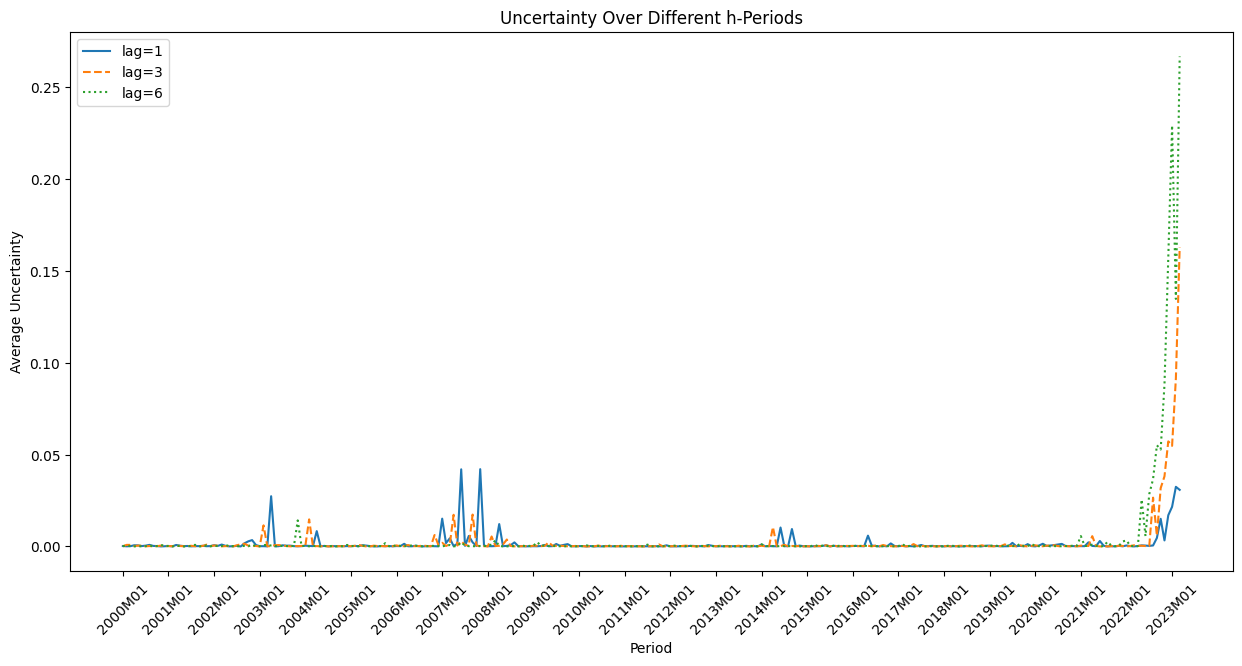

In [245]:
# Plot 'avg_uncertainty'
plt.figure(figsize=(15, 7))
plt.plot(uncertainties_1['period'], uncertainties_1['uncertainty'], label='lag=1', linestyle='-')
plt.plot(uncertainties_3['period'], uncertainties_3['uncertainty'], label='lag=3', linestyle='--')
plt.plot(uncertainties_6['period'], uncertainties_6['uncertainty'], label='lag=6', linestyle=':')


plt.title('Uncertainty Over Different h-Periods')
plt.xlabel('Period')
plt.ylabel('Average Uncertainty')
plt.legend()

# Set x-axis ticks at intervals of 12 periods and rotate x-labels
plt.xticks(uncertainties_1['period'][::12], rotation=45)
plt.show()



In [243]:
# save to csv
uncertainties_1.to_csv('../data/processed/uncertainty_index.csv', index=False, encoding='utf')